In [1]:
import torch

class Net(torch.nn.Module):

    def __init__(self, indim=1, outdim=1):
        super().__init__()
        self.actf = torch.tanh
        self.lin1 = torch.nn.Linear(indim, 100)
        self.lin2 = torch.nn.Linear(100, outdim)

    def forward(self, x):
        x = self.lin1(x)
        x = self.lin2(self.actf(x))
        return x.squeeze()

In [2]:
from torch.utils.data import Dataset

class MyDataset(Dataset):

    def __init__(self, in_tensor, out_tensor):
        self.inp = in_tensor
        self.out = out_tensor

    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        return self.inp[idx], self.out[idx]

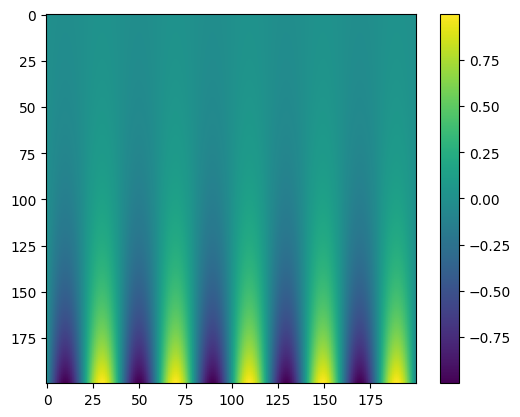

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def u(x, t):
    return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 200
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)

X, T = np.meshgrid(xs, ts)
U = u(X, T)

plt.imshow(U)
plt.colorbar()

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [5]:
from torch.utils.data import DataLoader

train_in = torch.tensor([[x, t] for x, t in zip(X.flatten(), T.flatten())], dtype=torch.float32, requires_grad=True)
train_out = torch.tensor(u(X.flatten(), T.flatten()), dtype=torch.float32)

train_in = train_in.to(DEVICE)
train_out = train_out.to(DEVICE)

train_dataset = MyDataset(train_in, train_out)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [62]:
import os
if not os.path.isdir('./models1'):
        os.mkdir('./models1') # Create directory of saving models.

In [63]:
from torch.optim import Adam
import math

best_loss = math.inf
model = Net(indim=2, outdim=1).to(DEVICE)
epochs = 500
optimizer = Adam(model.parameters(), lr=0.1)

loss_fcn = torch.nn.MSELoss()

for epoch in range(0, epochs):
    for batch_in, batch_out in train_dataloader:
        batch_in = batch_in.to(DEVICE)
        batch_out = batch_out.to(DEVICE)
        batch_in = batch_in.requires_grad_(True)
        model.train()
        def closure():
            optimizer.zero_grad()
            loss = loss_fcn(model(batch_in), batch_out)
            loss.backward()
            return loss
        optimizer.step(closure)
    model.eval()
    epoch_loss = loss_fcn(model(train_in), train_out)
    print(f'Epoch: {epoch+1} | Loss: {round(float(epoch_loss), 4)}')
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model.state_dict(), './models1/model1.ckpt')
        print('Saving model with loss {:.4f}...'.format(best_loss))

Epoch: 1 | Loss: 0.0734
Saving model with loss 0.0734...
Epoch: 2 | Loss: 0.0698
Saving model with loss 0.0698...
Epoch: 3 | Loss: 0.0728
Epoch: 4 | Loss: 0.0742
Epoch: 5 | Loss: 0.1395
Epoch: 6 | Loss: 0.0635
Saving model with loss 0.0635...
Epoch: 7 | Loss: 0.0595
Saving model with loss 0.0595...
Epoch: 8 | Loss: 0.0582
Saving model with loss 0.0582...
Epoch: 9 | Loss: 0.0471
Saving model with loss 0.0471...
Epoch: 10 | Loss: 0.0444
Saving model with loss 0.0444...
Epoch: 11 | Loss: 0.0329
Saving model with loss 0.0329...
Epoch: 12 | Loss: 0.0308
Saving model with loss 0.0308...
Epoch: 13 | Loss: 0.0288
Saving model with loss 0.0288...
Epoch: 14 | Loss: 0.0236
Saving model with loss 0.0236...
Epoch: 15 | Loss: 0.0336
Epoch: 16 | Loss: 0.0196
Saving model with loss 0.0196...
Epoch: 17 | Loss: 0.0181
Saving model with loss 0.0181...
Epoch: 18 | Loss: 0.0155
Saving model with loss 0.0155...
Epoch: 19 | Loss: 0.0165
Epoch: 20 | Loss: 0.0116
Saving model with loss 0.0116...
Epoch: 21 | Lo

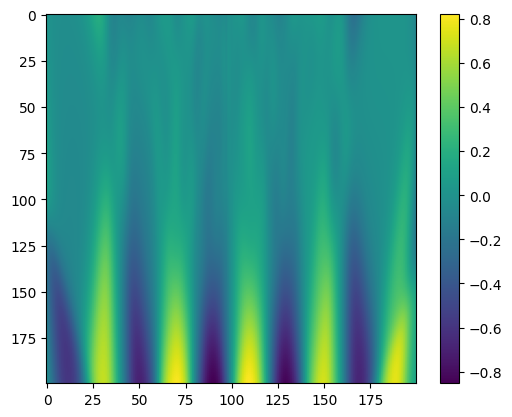

In [64]:
model_path = './models1/model1.ckpt'
model_pinn = Net(indim=2, outdim=1).to(DEVICE)
model_pinn.load_state_dict(torch.load(model_path, weights_only=True))
model_pinn.eval()

def u_model(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32).to(DEVICE)
    return model_pinn(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts, indexing='xy')

img = []
for x, t in zip(X, T):
    img.append(u_model(x, t).detach().cpu().numpy().tolist())

plt.imshow(img)
plt.colorbar()

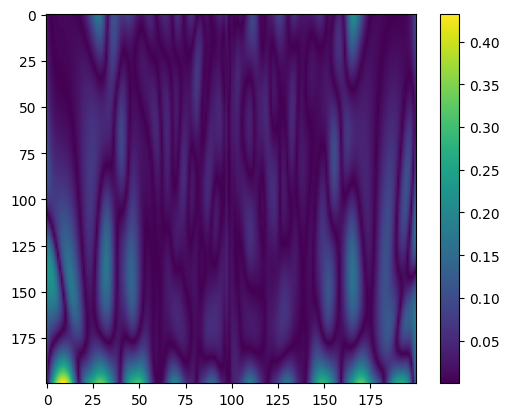

In [65]:
plt.imshow(abs(U-img))
plt.colorbar()

In [7]:
from torch.autograd import grad

def phys_loss_fun(inp, out):
    dudt = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,1]
    dudx = grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,0]
    d2udx2 = grad(dudx, inp, grad_outputs=torch.ones_like(dudx), create_graph=True, allow_unused=True)[0][:,0]
    return torch.nn.MSELoss()(d2udx2, 0.5*dudt)

In [8]:
bdry_pts = 200
xs_bdry = np.linspace(-5, 5, bdry_pts)
ts_bdry = np.asarray([0 for x in xs_bdry])
us_bdry = u(xs_bdry, ts_bdry)

train_in_bd = torch.tensor([[x, t] for x, t in zip(xs_bdry, ts_bdry)], dtype=torch.float32, requires_grad=True)
train_out_bd = torch.tensor(us_bdry, dtype=torch.float32)
  
train_in_bd = train_in_bd.to(DEVICE)
train_out_bd = train_out_bd.to(DEVICE)

In [68]:
import os
if not os.path.isdir('./models2'):
        os.mkdir('./models2') # Create directory of saving models.

In [69]:
from torch.optim import Adam
import math

best_loss = math.inf
model_pinn = Net(indim=2, outdim=1).to(DEVICE)

epochs = 500
optimizer_pinn = Adam(model_pinn.parameters(), lr=0.1)
loss_fcn = torch.nn.MSELoss()

for epoch in range(0, epochs):
    for batch_in, batch_out in train_dataloader:
        batch_in = batch_in.to(DEVICE)
        batch_out = batch_out.to(DEVICE)
        batch_in = batch_in.requires_grad_(True)
        model_pinn.train()
        def closure():
            optimizer_pinn.zero_grad()
            loss = loss_fcn(model_pinn(batch_in), batch_out)
            loss += phys_loss_fun(batch_in, model_pinn(batch_in))
            loss += loss_fcn(model_pinn(train_in_bd), train_out_bd)
            loss.backward()
            return loss
        optimizer_pinn.step(closure)
    model_pinn.eval()
    base_loss = loss_fcn(model_pinn(train_in), train_out)
    phys_loss = phys_loss_fun(train_in, model_pinn(train_in))
    bdry_loss = loss_fcn(model_pinn(train_in_bd), train_out_bd)
    epoch_loss = base_loss + phys_loss + bdry_loss

    print(f'Epoch: {epoch+1} | Loss: {round(float(epoch_loss), 4)} = {round(float(base_loss), 4)} + {round(float(phys_loss), 4)} + {round(float(bdry_loss), 4)}')
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model_pinn.state_dict(), './models2/model2.ckpt')
        print('Saving model with loss {:.4f}...'.format(best_loss))


Epoch: 1 | Loss: 0.5427 = 0.0658 + 0.0003 + 0.4767
Saving model with loss 0.5427...
Epoch: 2 | Loss: 0.5396 = 0.0673 + 0.0006 + 0.4717
Saving model with loss 0.5396...
Epoch: 3 | Loss: 0.5362 = 0.0656 + 0.0008 + 0.4698
Saving model with loss 0.5362...
Epoch: 4 | Loss: 0.7121 = 0.1561 + 0.0016 + 0.5545
Epoch: 5 | Loss: 0.5716 = 0.0876 + 0.0015 + 0.4825
Epoch: 6 | Loss: 0.5737 = 0.0903 + 0.0032 + 0.4802
Epoch: 7 | Loss: 0.603 = 0.1109 + 0.005 + 0.4871
Epoch: 8 | Loss: 0.5154 = 0.0699 + 0.0097 + 0.4358
Saving model with loss 0.5154...
Epoch: 9 | Loss: 0.5125 = 0.0636 + 0.0141 + 0.4347
Saving model with loss 0.5125...
Epoch: 10 | Loss: 0.5053 = 0.0578 + 0.0157 + 0.4319
Saving model with loss 0.5053...
Epoch: 11 | Loss: 0.4959 = 0.0587 + 0.0213 + 0.4158
Saving model with loss 0.4959...
Epoch: 12 | Loss: 0.4866 = 0.0568 + 0.0178 + 0.412
Saving model with loss 0.4866...
Epoch: 13 | Loss: 0.4916 = 0.0634 + 0.0299 + 0.3983
Epoch: 14 | Loss: 0.4773 = 0.0623 + 0.0306 + 0.3845
Saving model with lo

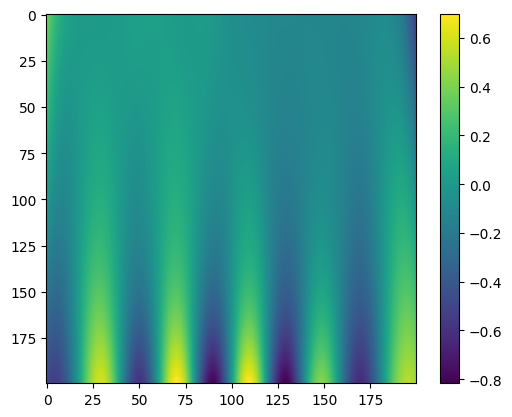

In [70]:
model_path = './models2/model2.ckpt'
model_pinn = Net(indim=2, outdim=1).to(DEVICE)
model_pinn.load_state_dict(torch.load(model_path, weights_only=True))
model_pinn.eval()

def u_model(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32).to(DEVICE)
    return model_pinn(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts, indexing='xy')

img = []
for x, t in zip(X, T):
    img.append(u_model(x, t).detach().cpu().numpy().tolist())

plt.imshow(img)
plt.colorbar()

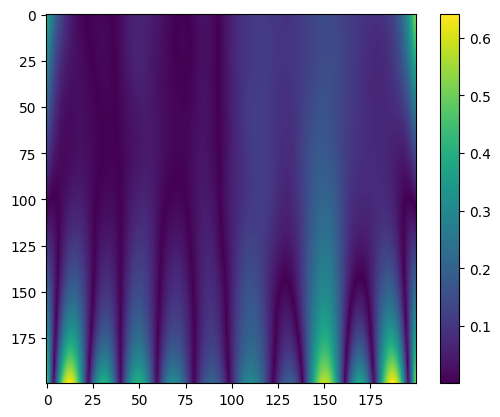

In [71]:
plt.imshow(abs(U-img))
plt.colorbar()

In [12]:
import os
if not os.path.isdir('./models3'):
        os.mkdir('./models3') # Create directory of saving models.

In [13]:
from torch.optim import Adam, LBFGS # LBFGS is much slower than Adam
import math

best_loss = math.inf

model_pinn_v2 = Net(indim=2, outdim=1).to(DEVICE)
epochs_adam = 200
epochs_lbfgs = 30
optimizer_pinn_adam = Adam(model_pinn_v2.parameters(), lr=0.1)
optimizer_pinn_lbfgs = LBFGS(model_pinn_v2.parameters(), lr=0.01)

loss_fcn = torch.nn.MSELoss()

for epoch in range(0, epochs_adam + epochs_lbfgs):
    current_optimizer = optimizer_pinn_adam if epoch <= epochs_adam else optimizer_pinn_lbfgs
    for batch_in, batch_out in train_dataloader:
        batch_in = batch_in.to(DEVICE)
        batch_out = batch_out.to(DEVICE)
        batch_in = batch_in.requires_grad_(True)
        model_pinn_v2.train()
        def closure():
            current_optimizer.zero_grad()
            loss = loss_fcn(model_pinn_v2(batch_in), batch_out)
            loss += phys_loss_fun(batch_in, model_pinn_v2(batch_in))
            loss += loss_fcn(model_pinn_v2(train_in_bd), train_out_bd)
            loss.backward()
            return loss
        current_optimizer.step(closure)
    model_pinn_v2.eval()
    base = loss_fcn(model_pinn_v2(train_in), train_out)
    phys = phys_loss_fun(train_in, model_pinn_v2(train_in))
    bdry = loss_fcn(model_pinn_v2(train_in_bd), train_out_bd)
    epoch_loss = base + phys + bdry
    print(f'Epoch: {epoch+1} | Loss: {round(float(epoch_loss), 4)} = {round(float(base), 4)} + {round(float(phys), 4)} + {round(float(bdry), 4)}')
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(model_pinn_v2.state_dict(), './models3/model3.ckpt')
        print('Saving model with loss {:.4f}...'.format(best_loss))

Epoch: 1 | Loss: 0.5388 = 0.0648 + 0.0006 + 0.4734
Saving model with loss 0.5388...
Epoch: 2 | Loss: 0.5898 = 0.0924 + 0.0007 + 0.4967
Epoch: 3 | Loss: 0.5631 = 0.0819 + 0.001 + 0.4802
Epoch: 4 | Loss: 0.6585 = 0.1301 + 0.0013 + 0.5272
Epoch: 5 | Loss: 0.5338 = 0.0689 + 0.0015 + 0.4634
Saving model with loss 0.5338...
Epoch: 6 | Loss: 0.536 = 0.0669 + 0.0038 + 0.4654
Epoch: 7 | Loss: 0.5233 = 0.0688 + 0.0073 + 0.4472
Saving model with loss 0.5233...
Epoch: 8 | Loss: 0.5081 = 0.0679 + 0.0115 + 0.4287
Saving model with loss 0.5081...
Epoch: 9 | Loss: 0.4916 = 0.0593 + 0.0205 + 0.4118
Saving model with loss 0.4916...
Epoch: 10 | Loss: 0.4834 = 0.0632 + 0.032 + 0.3882
Saving model with loss 0.4834...
Epoch: 11 | Loss: 0.458 = 0.0484 + 0.0522 + 0.3575
Saving model with loss 0.4580...
Epoch: 12 | Loss: 0.4571 = 0.0614 + 0.0611 + 0.3346
Saving model with loss 0.4571...
Epoch: 13 | Loss: 0.4654 = 0.0484 + 0.0981 + 0.3188
Epoch: 14 | Loss: 0.4449 = 0.0534 + 0.0861 + 0.3054
Saving model with los

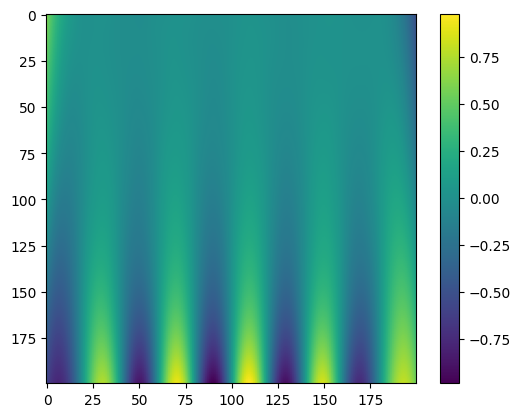

In [14]:
model_path = './models3/model3.ckpt'
model_pinn_v2 = Net(indim=2, outdim=1).to(DEVICE)
model_pinn_v2.load_state_dict(torch.load(model_path, weights_only=True))
model_pinn_v2.eval()

def u_model(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32).to(DEVICE)
    return model_pinn_v2(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts, indexing='xy')

img = []
for x, t in zip(X, T):
    img.append(u_model(x, t).detach().cpu().numpy().tolist())

plt.imshow(img)
plt.colorbar()

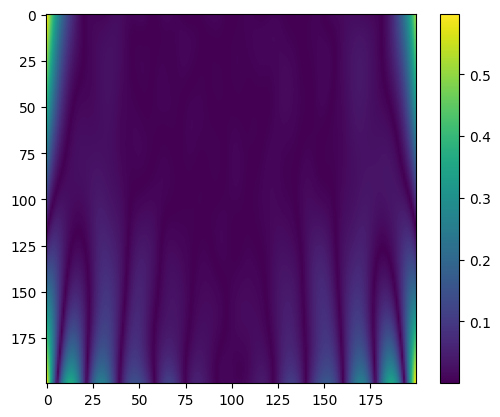

In [15]:
plt.imshow(abs(U-img))
plt.colorbar()